<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2022-1/07_Classifica%C3%A7%C3%A3o_D%C3%ADgitos_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 1.0.2
tensorflow: 2.8.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
print ( gpus )

[]


In [3]:
train_model = True
run_grid_search = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "ada_clf.joblib"
    # model_path = "models/ada_clf.joblib"
    scaler_path = "standard_scaler.joblib"
    # scaler_path = "models/standard_scaler.joblib"

### Amostra de dígitos

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:50000])]))[:, 1]
    reorder_valid = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[50000:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:50000] = mnist.data[reorder_train]
    mnist.target[:50000] = mnist.target[reorder_train]
    mnist.data[50000:60000] = mnist.data[reorder_valid + 50000]
    mnist.target[50000:60000] = mnist.target[reorder_valid + 50000]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:50000]
y_train = mnist.target[:50000]
X_valid_raw = mnist.data[50000:60000]
y_valid = mnist.target[50000:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_valid_raw.shape )
print ( X_test_raw.shape )

(50000, 784)
(10000, 784)
(10000, 784)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_valid = scaler.transform( X_valid_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
    dump( scaler, "standard_scaler.joblib")
    # dump( scaler, "models/standard_scaler.joblib")

StandardScaler()


9
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00483977 -0.00630411 -0.00447218 -0.00447218  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00447218 -0.00515922 -0.00963928 -0.01211949
 -0.01436819 -0.01737385 -0.02270852 -0.02757692 -0.02980096 -0.03081968
 -0.03110097 -0.03015775 -0.03021858 -0.02670023 -0.02103146 -0.01838468
 -0.0166327  -0.01131016 -0.00800445 -0.00479882  0.          0.
  0.          0.          0.          0.         -0.00447218 -0.00447218
 -0.00889745 -0.01236598 -0.01790015 -0.02738895 -0.0371536  -0.05175937
 -0.06602942 -0.082747   -0.10052937 -0.11606085 -0.12843945 -0.13638324
 -0.13592586 -0.1297393  -0.11885722 -0.10081914 -0.07808218 -0.05640676
 -0.03917999 -0.02442581 -0.01543332 -0.00857831  0.          0.
  0.          0.         -0.0048

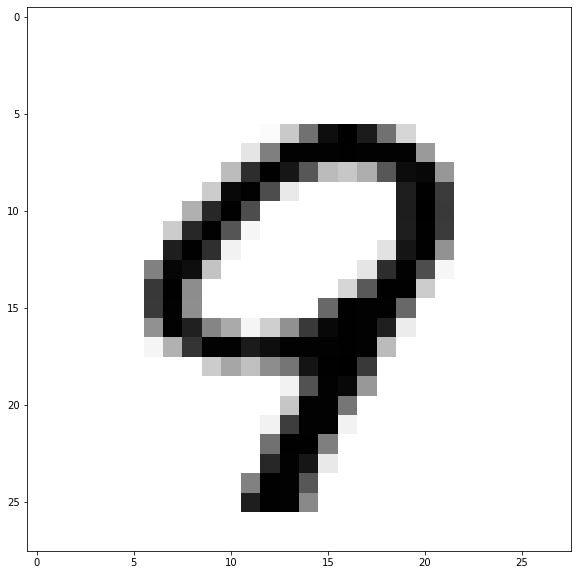

In [6]:
idx = 9900
print ( y_valid[ idx ] )
print ( X_valid[ idx ] )

fig = plt.figure( figsize=(10,10) )
plt.imshow( X_valid_raw[ idx ].reshape(28,28), cmap='binary' )

### Treinamento

In [7]:
shuffle_index = np.random.permutation( 50000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

### Definição do modelo

In [8]:
class Model:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
    def __call__(self, n_hidden, n_neurons, dropout):
        
        input_shape = self.input_shape
        learning_rate = self.learning_rate
        
        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )
        
        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )    
        model.add( keras.layers.Dense(10, activation="softmax") )
        
        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
        
        return model

def build_model(input_shape, learning_rate=5e-4, n_hidden=1, n_neurons=50, dropout=0.20 ):
    build_fn_ = Model( input_shape=input_shape, learning_rate=learning_rate )
    return build_fn_( n_hidden, n_neurons, dropout )


### Callbacks

In [9]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )


In [10]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )
    
    return callbacks_


### Learning rate

In [11]:
def find_max_learning_rate( X, y, X_val, y_val, lr_init=1e-4, lr_end=5e-2, steps=20, epochs=20, model_build_fn=build_model, callback_fn=callbacks, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callback_fn(patience=5)
        history_ = model_.fit( X, y, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_
        
    return results_

In [12]:
learning_rate_scan = False
epochs_lr_scan = 20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                X_train_shuffle, y_train_shuffle,
                X_valid, y_valid,
                lr_init=1e-4,
                lr_end=2e-2,
                steps=5,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                input_shape=X_train_shuffle.shape[1:],
                n_hidden=2,
                n_neurons=20,
                dropout=0.,
                )

In [13]:
if learning_rate_scan:
    # metrics_ = 'loss'
    metrics_ = 'val_loss'
    # metrics_ = 'val_accuracy'
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
    df_ = pd.DataFrame( np.full((epochs_lr_scan,len(columns_)),np.nan), columns=columns_ )
    fig_ = plt.figure( figsize=(12,10) )
    for i_lr_,col_ in enumerate(columns_):
        df_[col_] = pd.Series( results[ metrics_ ][i_lr_] )
        df_[col_].plot()
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )
    # plt.ylim( 0.80, 1.05 )

In [14]:
if learning_rate_scan:
    metrics_train_ = 'loss'
    metrics_valid_ = 'val_loss'
    colors_=['tab:red','tab:green','tab:blue','tab:orange', 'tab:purple', 'tab:gray']
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
    df_ = pd.DataFrame( np.full((epochs_lr_scan,2*len(columns_)),np.nan), columns=( 2 * columns_ ) )
    fig_ = plt.figure( figsize=(12,10) )
    for i_lr_,col_ in enumerate(columns_):
        df_[ "train_{}".format( col_ ) ] = pd.Series( results[ metrics_train_ ][i_lr_] )
        df_[ "train_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ] )
        df_[ "valid_{}".format( col_ ) ] = pd.Series( results[ metrics_valid_ ][i_lr_] )
        df_[ "valid_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ], linestyle='dashed' )
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )

#### Exponential learning rate scheduling

(1e-05, 0.02)

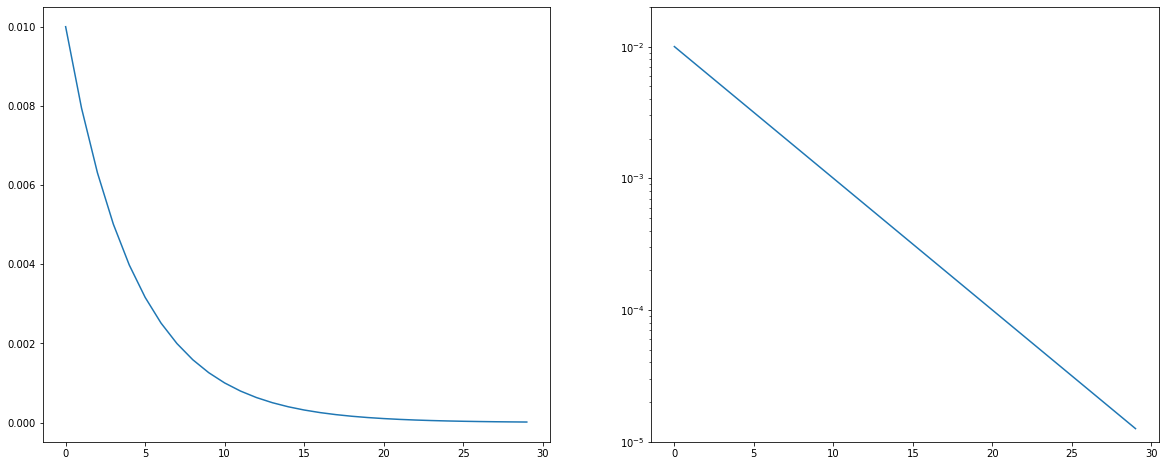

In [15]:
exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

fig, axes = plt.subplots( 1, 2, figsize=(20,8) )
xplot__ = np.arange(30)
axes[0].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].set_yscale( 'log' )
axes[1].set_ylim( 1e-5, 2e-2 )

In [16]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=1e-2,
    n_hidden=2,
    n_neurons=20,
    dropout=0.
    )

callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )
epochs_ = 20
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 [==============================] - 5s 2ms/step - loss: 0.3641 - accuracy: 0.8990 - val_loss: 0.2380 - val_accuracy: 0.9281 - lr: 0.0100
Epoch 2/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2389 - accuracy: 0.9315 - val_loss: 0.2142 - val_accuracy: 0.9403 - lr: 0.0079
Epoch 3/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1974 - accuracy: 0.9427 - val_loss: 0.2214 - val_accuracy: 0.9406 - lr: 0.0063
Epoch 4/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1619 - accuracy: 0.9515 - val_loss: 0.1918 - val_accuracy: 0.9482 - lr: 0.0050
Epoch 5/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1378 - accuracy: 0.9586 - val_loss: 0.1887 - val_accuracy: 0.9501 - lr: 0.0040
Epoch 6/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0

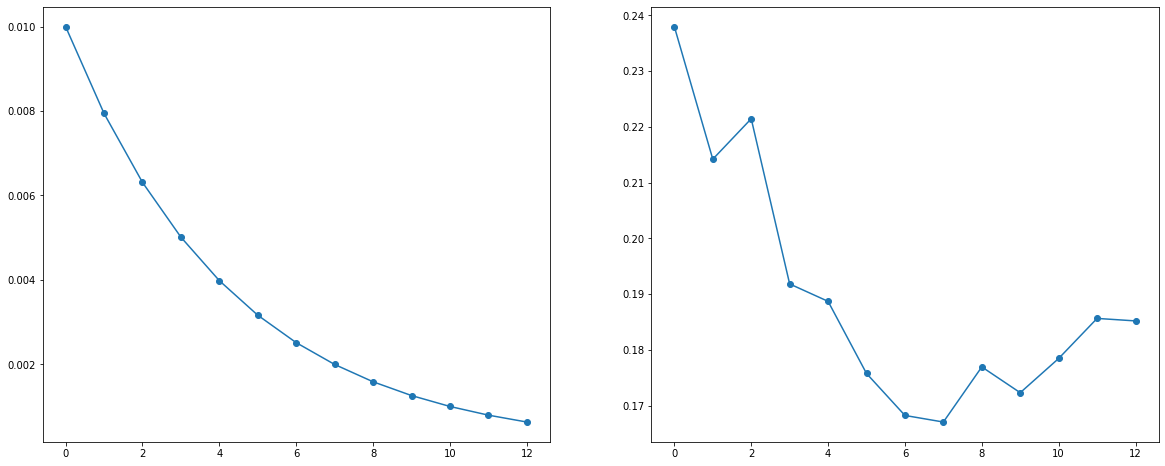

In [17]:
fig, axes = plt.subplots( 1, 2, figsize=(20,8) )
axes[0].plot( history.epoch, history.history['lr'], 'o-' )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-' )

### Hyperparameter scan

In [21]:
# Constant learning rate
# learning_rate = 3e-4

n_iter_search = 5
cv = 4
n_jobs = -1
epochs_grid_search = 20
# scoring = 'accuracy'
# scoring = 'f1'

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()
        
    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    build_fn_ = Model( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
    keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

    param_distribs = {
        "n_hidden": np.arange(2,6),
        "n_neurons": 2 ** np.arange(4,8),
        "dropout":  0.1 * np.arange(2,6),
        "batch_size": 2 ** np.arange(5,8)
        }

    grid_search = RandomizedSearchCV(
        keras_clf,
        param_distribs,
        n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=n_jobs, refit=False, random_state=42
        )

    callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )
    print ( callbacks_ )
    grid_search.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid), callbacks=callbacks_ )
    
    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )
    
    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2022/04/10 23:27:42
[<keras.callbacks.EarlyStopping object at 0x7fba487fc750>, <keras.callbacks.LearningRateScheduler object at 0x7fba487fc450>]
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_neurons': 128, 'n_hidden': 5, 'dropout': 0.2, 'batch_size': 128}
0.9728400111198425
{'mean_fit_time': array([139.41570288,  47.58253682,  80.95333081, 144.38849401,
        64.11707467]), 'std_fit_time': array([ 8.82531509, 21.81045416,  6.70721955,  0.93412413, 12.26603451]), 'mean_score_time': array([1.35319293, 0.74146301, 1.15501338, 0.87482458, 0.9001466 ]), 'std_score_time': array([0.28284767, 0.20253677, 0.46537391, 0.06895233, 0.06426556]), 'param_n_neurons': masked_array(data=[32, 16, 16, 128, 32],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_hidden': masked_array(data=[5, 4, 5, 5, 2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_dropout': masked_array(data=[0.4, 0.2, 0.2, 0.2, 0.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_batch_size': masked_array(data=[32, 128, 64, 1

### Ajuste do modelo com parâmetros otimizados

In [23]:
model_final = None
history = None

if train_model:
    params = {'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20}
    batch_size = 32
    if run_grid_search: 
        params = grid_search.best_params_.copy()
        batch_size = params[ 'batch_size' ]
        params.pop( 'batch_size' )
    print ( params, "batch_size: {}".format( batch_size ) )
    
    model_final = build_model(input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2, **params )
    log_dir="keras_logs"
    callbacks_ = callbacks(patience=5, lr_scheduler_fn=exponential_decay_, log_dir=log_dir)
    print ( callbacks_ )
    epochs_ = 50
    history = model_final.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=callbacks_ )
else:
    model_final = keras.models.load_model( model_path )
    
model_final.summary()

{'n_neurons': 128, 'n_hidden': 5, 'dropout': 0.2} batch_size: 128
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 5
Number of neurons per layer: 128
Dropout rate: 0.2
Log dir: keras_logs/run_2022_04_10-23_49_26
[<keras.callbacks.EarlyStopping object at 0x7fba4edc6510>, <keras.callbacks.LearningRateScheduler object at 0x7fba4edc6d10>, <keras.callbacks.TensorBoard object at 0x7fba4f6cdcd0>]
Epoch 1/50
391/391 [==============================] - 7s 14ms/step - loss: 0.6466 - accuracy: 0.8321 - val_loss: 0.2853 - val_accuracy: 0.9327 - lr: 0.0100
Epoch 2/50
391/391 [==============================] - 7s 18ms/step - loss: 0.4018 - accuracy: 0.8994 - val_loss: 0.2638 - val_accuracy: 0.9406 - lr: 0.0079
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 0.3198 - accuracy: 0.9213 - val_loss: 0.1707 - val_accuracy: 0.9595 - lr: 0.0063
Epoch 4/50
391/391 [==============================] - 4s 11ms/step - loss: 0.2718 - accuracy: 0.9331 -

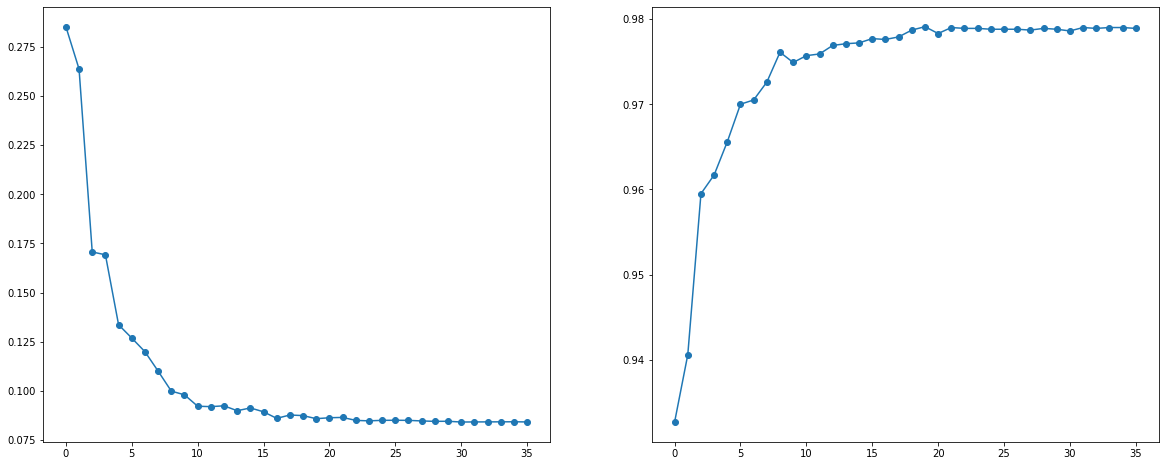

In [25]:
if history is not None:
    fig, axes = plt.subplots( 1, 2, figsize=(20,8) )
    axes[0].plot( history.epoch, history.history['val_loss'], 'o-' )
    axes[1].plot( history.epoch, history.history['val_accuracy'], 'o-' )

In [27]:
model_final.evaluate( X_train, y_train ) # sem dropout

1563/1563 [==============================] - 5s 3ms/step - loss: 0.0313 - accuracy: 0.9905


[0.031258560717105865, 0.9904999732971191]

In [28]:
model_final.evaluate( X_valid, y_valid )

313/313 [==============================] - 1s 3ms/step - loss: 0.0841 - accuracy: 0.9786


[0.08407847583293915, 0.978600025177002]

### Teste

In [30]:
model_final.evaluate( X_test, y_test )

313/313 [==============================] - 1s 3ms/step - loss: 0.0939 - accuracy: 0.9758


[0.0938711166381836, 0.9757999777793884]

In [32]:
y_test_proba = model_final.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

[[9.9999166e-01 2.3396106e-11 2.1499875e-06 ... 1.8348089e-08
  1.4863058e-06 7.5409133e-07]
 [9.9999988e-01 2.1641050e-15 7.2424747e-08 ... 2.9593960e-12
  1.5807188e-08 1.3369381e-08]
 [9.9999881e-01 4.9930898e-13 6.5207695e-07 ... 2.1237934e-10
  2.7177146e-07 1.6610043e-07]
 ...
 [1.2628849e-08 3.7359605e-08 1.2738866e-06 ... 4.7684949e-05
  4.5293917e-05 9.9957722e-01]
 [1.3917352e-09 8.8634193e-09 3.5189603e-07 ... 2.1170086e-05
  1.0514721e-05 9.9978346e-01]
 [1.9709151e-10 1.6722417e-09 7.7144293e-08 ... 8.1247445e-06
  2.1745814e-06 9.9987602e-01]]
[0 0 0 ... 9 9 9]


In [33]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9758


242
0: 10
1: 9
2: 29
3: 24
4: 29
5: 31
6: 14
7: 28
8: 33
9: 35


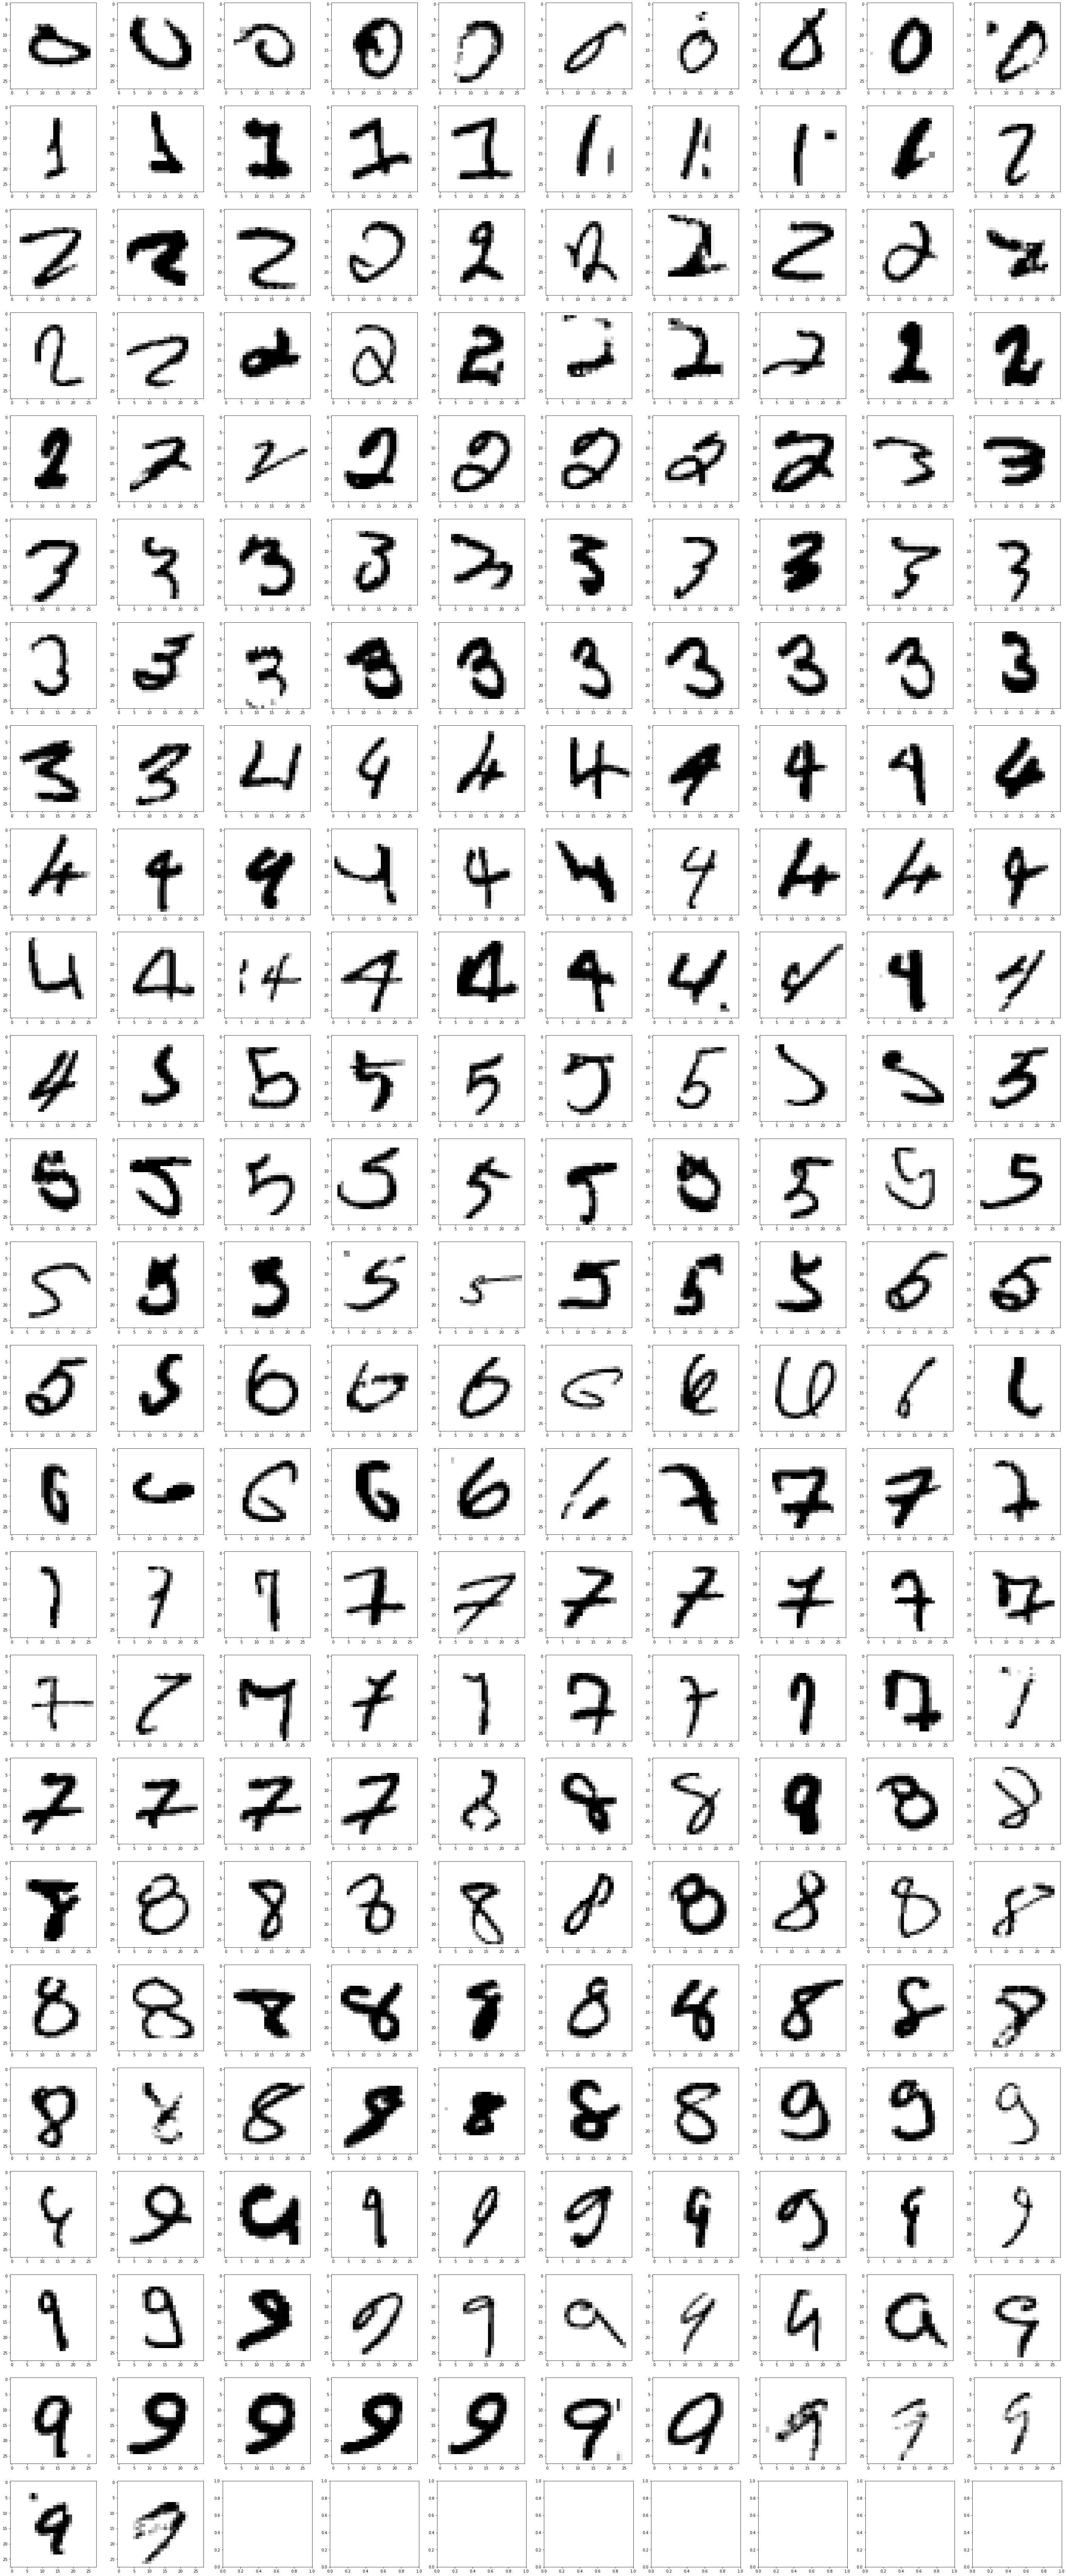

In [37]:
def plot_digits( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break
        
        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ].reshape(28,28), cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{}: {}".format( label_, np.sum( msk__ ) ) )

plot_digits( X_test_raw[ msk_error_ ], 250 )